In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/multi_classification_train.csv')

Mounted at /content/drive


In [4]:
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]
print(train_size)
train_data.shape

38400


(38400, 22)

In [5]:
x_train = train_data.iloc[:, 1:-1]
y_train = train_data.iloc[:, -1].values
x_test = test_data.iloc[:, 1:-1]
y_test = test_data.iloc[:, -1].values
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(38400, 20)
(38400,)
(9600, 20)
(9600,)


In [6]:
x_train_normalized = (x_train - x_train.mean()) / x_train.std()
x_test_normalized = (x_test - x_train.mean()) / x_train.std()

In [7]:
train_x = np.hstack((np.ones((x_train_normalized.shape[0], 1)), x_train_normalized))
test_x = np.hstack((np.ones((x_test_normalized.shape[0], 1)), x_test_normalized))

In [8]:
num_classes = len(np.unique(y_train))
y_train_encoded = np.zeros((y_train.size, num_classes))
y_train_encoded[np.arange(y_train.size), y_train - 1] = 1
y_test_encoded = np.zeros((y_test.size, num_classes))
y_test_encoded[np.arange(y_test.size), y_test - 1] = 1
print(y_train_encoded.shape)
print(y_test_encoded.shape)

(38400, 5)
(9600, 5)


In [9]:
iterations = 10000
learning_rate = 0.1
w = np.zeros((train_x.shape[1], num_classes))
print(w.shape)

(21, 5)


In [10]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability improvement
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [11]:
def cost(x, y, w):
    z = np.dot(x, w)
    y_pred = softmax(z)
    return -np.mean(np.sum(y * np.log(y_pred + 1e-15), axis=1))

In [12]:
def grad(x, y, w, learning_rate, iterations):
    m = x.shape[0]
    j_hist = []
    for _ in range(iterations):
        z = np.dot(x, w)
        y_pred = softmax(z)
        error = y_pred - y
        dj_dw = (1 / m) * np.dot(x.T, error)
        w = w - learning_rate * dj_dw
        j_hist.append(cost(x, y, w))
    return w, j_hist , y_pred

In [13]:
w, j_hist, y_pred = grad(train_x, y_train_encoded, w, learning_rate, iterations)

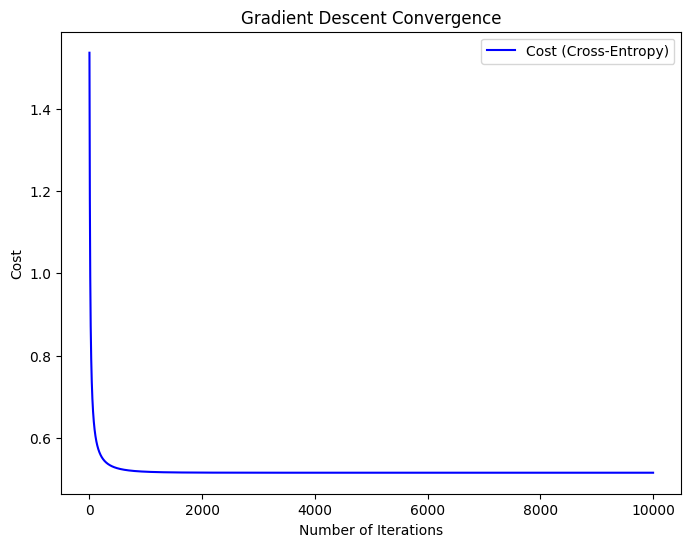

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(range(iterations), j_hist, label='Cost (Cross-Entropy)', color='blue')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.title('Gradient Descent Convergence')
plt.legend()
plt.show()

In [15]:
z_test = np.dot(test_x, w)
y_pred_test = softmax(z_test)
y_pred_labels = np.argmax(y_pred_test, axis=1)
print(y_pred_labels.shape)

(9600,)


In [16]:
thresholds = np.arange(0.1, 0.9, 0.1)


In [17]:
def compute_metrics(y_true, y_pred, thresholds):
    classes = np.unique(y_true)
    max_f1_scores = []

    for cls in classes:
        f1_scores = []
        for threshold in thresholds:
            y_pred_binary = (y_pred[:, cls - 1] >= threshold).astype(int)
            y_true_binary = (y_true == cls).astype(int)

            tp = np.sum((y_pred_binary == 1) & (y_true_binary == 1))
            fp = np.sum((y_pred_binary == 1) & (y_true_binary == 0))
            fn = np.sum((y_pred_binary == 0) & (y_true_binary == 1))

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            f1_scores.append(f1)

        max_f1_scores.append(max(f1_scores))

    return max_f1_scores

In [18]:
max_f1_scores = compute_metrics(y_test, y_pred_test, thresholds)

In [19]:
for cls, f1 in enumerate(max_f1_scores, start=1):
    print(f"Class {cls}: F1 Score = {f1:.4f}")


Class 1: F1 Score = 0.6523
Class 2: F1 Score = 0.8938
Class 3: F1 Score = 0.8765
Class 4: F1 Score = 0.8089
Class 5: F1 Score = 0.7723


In [20]:
from google.colab import drive
drive.mount('/content/drive')
new_data = pd.read_csv('/content/drive/MyDrive/multi_classification_test.csv')
new_data.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(12000, 21)

In [21]:
x_new = new_data.iloc[:, 1:]
x_new_normalized = (x_new - x_train.mean()) / x_train.std()
new_x = np.hstack((np.ones((x_new_normalized.shape[0], 1)), x_new_normalized))
print(new_x.shape)

(12000, 21)


In [22]:
z_new = np.dot(new_x, w)
y_pred_new = softmax(z_new)
y_pred_labels_new = np.argmax(y_pred_new, axis=1)
print(y_pred_labels_new.shape)

(12000,)


In [23]:
print("Predicted Labels:")
print(y_pred_labels_new)

Predicted Labels:
[2 0 0 ... 2 4 0]


In [24]:
y_pred_new = pd.DataFrame(y_pred_labels_new, columns=['Predicted_Probabilities'])
y_pred_new.to_csv('multiclassifications_test_predictions_probabilities.csv', index=False)
print(os.getcwd())
files.download('/content/multiclassifications_test_predictions_probabilities.csv')

/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
y_pred_labels_new = pd.DataFrame(y_pred_labels_new, columns=['Predicted_Probabilities'])
y_pred_labels_new.to_csv('multiclassifications_test_predictions_classes.csv', index=False)
print(os.getcwd())
files.download('/content/multiclassifications_test_predictions_classes.csv')


/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>